In [1]:
from GLC.data_loading.common import load_patch

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import annotations
from pathlib import Path
from typing import Optional, Union, TYPE_CHECKING

import numpy as np
from PIL import Image
import tifffile

In [3]:
df_obs_train = pd.read_csv("../data/observations/observations_fr_train.csv", sep=";", index_col="observation_id", nrows = 10000)

In [4]:
df_obs_train.species_id.values

array([241, 101, 700, ..., 727, 234,  70], dtype=int64)

In [5]:
observation_ids = df_obs_train.index

In [6]:
image = load_patch(observation_ids[0], "../data", data="landcover")

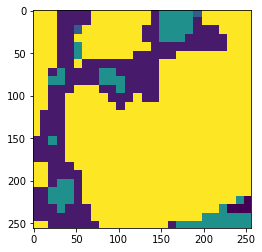

In [7]:
for i in range(0, len(image)):
    plt.imshow(image[i], interpolation='nearest')
    plt.show()

In [8]:
training_data = []
training_label = df_obs_train.species_id.values
for i in observation_ids:
    training_data.append(load_patch(i, "../data", data="rgb")[0])

In [9]:
##for image in training_data:
##    plt.imshow(image, interpolation='nearest')
##    plt.show()
##print(len(training_data), len(training_label))

In [10]:
import os
import torch
import numpy as np
from torch import from_numpy
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [11]:
def load_landcover(
    observation_id: Union[int, str],
    patches_path: Union[str, Path]
) -> Patches:

    observation_id = str(observation_id)

    region = "patches-fr"
    subfolder1 = observation_id[-2:]
    subfolder2 = observation_id[-4:-2]

    filename = Path(patches_path) / region / subfolder1 / subfolder2 / observation_id

    rgb_filename = filename.with_name(filename.stem + "_rgb.jpg")
    rgb_patch = Image.open(rgb_filename)
    transform = transforms.Compose([transforms.PILToTensor()])
  
    img_tensor = transform(rgb_patch)
    return img_tensor

class CustomImageDataset(Dataset):
    
    def __init__ (self,transform=None, target_transform=None):
        self.img_labels = pd.read_csv("../data/observations/observations_fr_train.csv", sep=";", index_col="observation_id", nrows = 10000).species_id.values
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, index):
        image = load_landcover(observation_ids[index], "../data")
        label = self.img_labels[index]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
        

In [12]:
from GLC.data_loading.pytorch_dataset import GeoLifeCLEF2022Dataset
longdataset = GeoLifeCLEF2022Dataset("../data",subset = "train", 
                                 region = 'fr', 
                                 patch_data = 'rgb', \
                                 use_rasters = False,\
                                 #transform = get_train_transforms(),\
                                 transform = None)

train_size = int(0.005 * 0.8 * len(longdataset))
val_size = len(longdataset) - train_size


t1, t2 = torch.utils.data.random_split(longdataset, [train_size, val_size])
train_dataset, val_dataset = torch.utils.data.random_split(t1, [int(0.8 * len(t1)), len(t1) - int(0.8 * len(t1))])
print(len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=16,num_workers = 0,shuffle = True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers = 0,shuffle = False,drop_last=True)

2100


In [13]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pretrainedmodels
import gc


from torchvision.models.resnet import ResNet, BasicBlock


import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(196608, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 17036),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
def train(model, train_loader, optimizer, loss_fn):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        inputs = inputs.float()
        outputs = model(inputs)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 99:
            last_loss = running_loss / 100
            running_loss = 0.

    return last_loss

model = NeuralNetwork().to(device)

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss(ignore_index = 1)
train(model, train_loader, optimizer, loss_fn)

5.799741315424987e+25

In [19]:
image, label = train_dataset[0]
print(label)

281


In [40]:
def is_in_top_30(outputs, species, speciesId):
    values, indices = torch.topk(outputs, 30)
    for i in indices:
        if(species[i] == speciesId):
            return True
    return False

species = df_obs_train.species_id.values
correct = 0

for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.float()
        outputs = model(inputs)
        for index, item in enumerate(outputs):
            if(is_in_top_30(item, species, labels[index])):
                correct += 1
        if (i == 50):
            break
        
print(correct)

18
